# FIFA World Cup 2018

I'm going to treat the entire country as a black box entity that somehow just finds players that fairly consistently do well.

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
from rosey.helpers import suppress_warnings

import matplotlib.pyplot as graph
import seaborn as sns

from pprint import pprint

import trueskill
from trueskill import Rating, rate_1vs1, quality_1vs1, BETA
from IPython.display import display

graph.style.use('fivethirtyeight')
suppress_warnings()


def win_prob(team_a, team_b):
    delta_mu = team_a.mu - team_b.mu
    sum_std = team_a.sigma ** 2 + team_b.sigma ** 2
    n_players = 2
    return trueskill.global_env().cdf(delta_mu / (math.sqrt(n_players * (BETA ** 2) + sum_std)))

/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
past_matches = pd.read_csv('data/fifa-2018/fifa-world-cup/WorldCupMatches.csv')
past_matches.dropna(inplace=True)

past_matches.rename(columns={'Home Team Initials': 'a', 'Away Team Initials': 'b'}, inplace=True)

display(past_matches.head())
display(past_matches.tail())
print(past_matches.shape)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,a,b
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,a,b
847,2014.0,05 Jul 2014 - 17:00,Quarter-finals,Arena Fonte Nova,Salvador,Netherlands,0.0,0.0,Costa Rica,Netherlands win on penalties (4 - 3),51179.0,0.0,0.0,Ravshan IRMATOV (UZB),RASULOV Abduxamidullo (UZB),KOCHKAROV Bakhadyr (KGZ),255953.0,300186488.0,NED,CRC
848,2014.0,08 Jul 2014 - 17:00,Semi-finals,Estadio Mineirao,Belo Horizonte,Brazil,1.0,7.0,Germany,,58141.0,0.0,5.0,RODRIGUEZ Marco (MEX),TORRENTERA Marvin (MEX),QUINTERO Marcos (MEX),255955.0,300186474.0,BRA,GER
849,2014.0,09 Jul 2014 - 17:00,Semi-finals,Arena de Sao Paulo,Sao Paulo,Netherlands,0.0,0.0,Argentina,Argentina win on penalties (2 - 4),63267.0,0.0,0.0,C�neyt �AKIR (TUR),DURAN Bahattin (TUR),ONGUN Tarik (TUR),255955.0,300186490.0,NED,ARG
850,2014.0,12 Jul 2014 - 17:00,Play-off for third place,Estadio Nacional,Brasilia,Brazil,0.0,3.0,Netherlands,,68034.0,0.0,2.0,HAIMOUDI Djamel (ALG),ACHIK Redouane (MAR),ETCHIALI Abdelhak (ALG),255957.0,300186502.0,BRA,NED
851,2014.0,13 Jul 2014 - 16:00,Final,Estadio do Maracana,Rio De Janeiro,Germany,1.0,0.0,Argentina,Germany win after extra time,74738.0,0.0,0.0,Nicola RIZZOLI (ITA),Renato FAVERANI (ITA),Andrea STEFANI (ITA),255959.0,300186501.0,GER,ARG


(850, 20)


Turns out the data is already in out so we don't need to parse to datetime to sort them.

Now it's time to make all the countries and see who is the best today!

In [3]:
team_names = set(past_matches['a'].tolist() + past_matches['b'].tolist())
team_names = list(team_names)

print(len(team_names))
print(team_names)

82
['ALG', 'POR', 'PAR', 'ESP', 'GER', 'ISR', 'KSA', 'SVK', 'ANG', 'CIV', 'COL', 'CUB', 'ARG', 'IRN', 'SCO', 'AUT', 'FRA', 'RUS', 'RSA', 'CZE', 'TCH', 'NIR', 'TUN', 'KUW', 'HUN', 'SUI', 'PER', 'BUL', 'IRQ', 'MEX', 'CMR', 'IRL', 'MAR', 'JAM', 'JPN', 'SCG', 'TOG', 'SRB', 'BIH', 'URU', 'NOR', 'URS', 'INH', 'PRK', 'SLV', 'USA', 'UAE', 'TUR', 'NZL', 'BOL', 'CAN', 'POL', 'AUS', 'DEN', 'ECU', 'CHI', 'TRI', 'SWE', 'UKR', 'ITA', 'GDR', 'HAI', 'GHA', 'CHN', 'EGY', 'HON', 'ROU', 'GRE', 'SEN', 'CRC', 'BRA', 'ZAI', 'CRO', 'WAL', 'KOR', 'NED', 'YUG', 'SVN', 'BEL', 'NGA', 'FRG', 'ENG']


# Initialise Models

In [4]:
teams = {name: Rating() for name in team_names}
pprint(teams)

{'ALG': trueskill.Rating(mu=25.000, sigma=8.333),
 'ANG': trueskill.Rating(mu=25.000, sigma=8.333),
 'ARG': trueskill.Rating(mu=25.000, sigma=8.333),
 'AUS': trueskill.Rating(mu=25.000, sigma=8.333),
 'AUT': trueskill.Rating(mu=25.000, sigma=8.333),
 'BEL': trueskill.Rating(mu=25.000, sigma=8.333),
 'BIH': trueskill.Rating(mu=25.000, sigma=8.333),
 'BOL': trueskill.Rating(mu=25.000, sigma=8.333),
 'BRA': trueskill.Rating(mu=25.000, sigma=8.333),
 'BUL': trueskill.Rating(mu=25.000, sigma=8.333),
 'CAN': trueskill.Rating(mu=25.000, sigma=8.333),
 'CHI': trueskill.Rating(mu=25.000, sigma=8.333),
 'CHN': trueskill.Rating(mu=25.000, sigma=8.333),
 'CIV': trueskill.Rating(mu=25.000, sigma=8.333),
 'CMR': trueskill.Rating(mu=25.000, sigma=8.333),
 'COL': trueskill.Rating(mu=25.000, sigma=8.333),
 'CRC': trueskill.Rating(mu=25.000, sigma=8.333),
 'CRO': trueskill.Rating(mu=25.000, sigma=8.333),
 'CUB': trueskill.Rating(mu=25.000, sigma=8.333),
 'CZE': trueskill.Rating(mu=25.000, sigma=8.333),


In [5]:
%%time
# Update skill using bayesian stats
for i, row in past_matches.iterrows():
    a, b = row['a'], row['b']
    
    a_goals = row['Home Team Goals']
    b_goals = row['Away Team Goals']
    
    if a_goals > b_goals:
        # A Wins
        winner_rating, loser_rating = rate_1vs1(teams[a], teams[b])
        teams[a] = winner_rating
        teams[b] = loser_rating
        
    elif a_goals < b_goals:
        # B Wins
        winner_rating, loser_rating = rate_1vs1(teams[b], teams[a])
        teams[b] = winner_rating
        teams[a] = loser_rating
        
    else:
        # Draw
        a_new_rating, b_new_rating = rate_1vs1(teams[a], teams[b], drawn=True)
        teams[a] = a_new_rating
        teams[b] = b_new_rating
        
pprint(teams)

{'ALG': trueskill.Rating(mu=25.946, sigma=2.089),
 'ANG': trueskill.Rating(mu=23.741, sigma=3.727),
 'ARG': trueskill.Rating(mu=31.319, sigma=0.998),
 'AUS': trueskill.Rating(mu=25.524, sigma=2.308),
 'AUT': trueskill.Rating(mu=29.384, sigma=1.511),
 'BEL': trueskill.Rating(mu=26.858, sigma=1.299),
 'BIH': trueskill.Rating(mu=22.737, sigma=4.629),
 'BOL': trueskill.Rating(mu=18.028, sigma=4.107),
 'BRA': trueskill.Rating(mu=33.314, sigma=0.941),
 'BUL': trueskill.Rating(mu=24.811, sigma=1.647),
 'CAN': trueskill.Rating(mu=18.105, sigma=5.370),
 'CHI': trueskill.Rating(mu=29.180, sigma=1.408),
 'CHN': trueskill.Rating(mu=17.663, sigma=5.469),
 'CIV': trueskill.Rating(mu=25.217, sigma=2.746),
 'CMR': trueskill.Rating(mu=26.439, sigma=1.552),
 'COL': trueskill.Rating(mu=27.894, sigma=1.834),
 'CRC': trueskill.Rating(mu=28.331, sigma=1.810),
 'CRO': trueskill.Rating(mu=28.022, sigma=1.995),
 'CUB': trueskill.Rating(mu=24.897, sigma=4.662),
 'CZE': trueskill.Rating(mu=23.701, sigma=4.919),


In [6]:
ratings = pd.DataFrame([(k, v.mu, v.sigma) for k, v in teams.items()], columns=['name', 'skill', 'sd'])

display(ratings.sort_values(by='skill', ascending=False))

,name,skill,sd
4,GER,33.474017,1.241809
70,BRA,33.314170,0.940663
80,FRG,32.862492,1.087475
75,NED,32.172358,1.095652
59,ITA,31.357034,0.960135
12,ARG,31.318842,0.998126
68,SEN,30.504668,3.006538
81,ENG,30.498369,1.042673
16,FRA,30.435863,1.081231
51,POL,30.024109,1.454822


In [ ]:
# Current Updates


Match Quality: 86.1%
P(CRO beats DEN): 38.1%


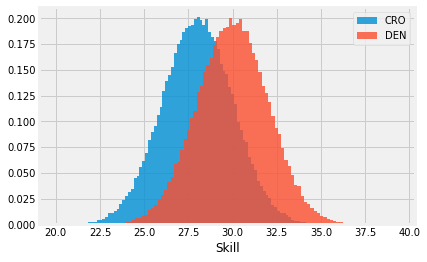

In [10]:
a, b = 'CRO', 'DEN'

print(f'Match Quality: {quality_1vs1(teams[a], teams[b]):.1%}')

n_trials = int(1e5)
a_rvs = stats.norm(teams[a].mu, teams[a].sigma).rvs(n_trials)
b_rvs = stats.norm(teams[b].mu, teams[b].sigma).rvs(n_trials)

print(f'P({a} beats {b}): {win_prob(teams[a], teams[b]):0.1%}')

graph.hist(a_rvs, alpha=0.8, bins=100, normed=True, label=a)
graph.hist(b_rvs, alpha=0.8, bins=100, normed=True, label=b)
graph.xlabel('Skill')
graph.legend()
graph.show()

_Stephen Anthony Rose_